In [1]:
#the sample code
#load datasets
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

#优化器
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)
           

 #求梯度
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        it.iternext()   
        
    return grad

#激活函数
class Relu:
    def __init__(self):
        self.mask = None
        self.mask1 = None

    def forward(self, x):
        self.mask = (x <= 0)
        self.mask1 = (x >= 6)
        out = x.copy()
        out[self.mask] = 0
        out[self.mask1] = 6

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dout[self.mask1] = 0
        dx = dout

        return dx
    
#softmax以及交叉熵层
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax的输出
        self.t = None # 监督数据

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 监督数据是one-hot-vector的情况
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

#dropout层
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask
    
#反向传播梯度求解
def gradient(self, x, t):
    # forward
    self.loss(x, t)

    # backward
    dout = 1
    dout = self.last_layer.backward(dout)

    tmp_layers = self.layers.copy()
    tmp_layers.reverse()
    for layer in tmp_layers:
        dout = layer.backward(dout)

    # 设定
    grads = {}
    for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
        grads['W' + str(i+1)] = self.layers[layer_idx].dW
        grads['b' + str(i+1)] = self.layers[layer_idx].db

    return grads

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from builtins import range
from six.moves import cPickle as pickle
from imageio import imread
import platform
import sys, os

In [3]:
#process the data
cifar10_dir = 'cifar-10-batches-py/'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
#打印训练集与测试集数量、图片大小
print('Training data shape: ', X_train.shape)  #np.array数组的shape属性，返回各维度的维数
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
#从左到右分别为训练集图像数量、高、宽以及通道数

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


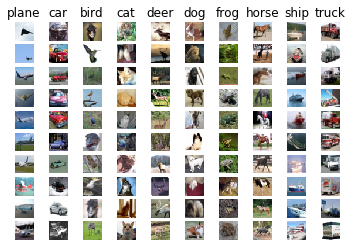

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10 #每个类别取10张
for y, clss in enumerate(classes): #enumerate遍历输出函数，输出下标及列表数据，y为下标，cls为类名
    idxs = np.flatnonzero(y_train == y) #输出非零元素位置，获取图片对应标签的下标，按种类分类
    idxs = np.random.choice(idxs, samples_per_class, replace=False) 
    #随机选取每个类的10个下标值，replace参数决定是否有重复随机数
    for i, idx in enumerate(idxs): #返回图
        plt_idx = i * num_classes + y + 1 #输出的图片的序号，作为绘图函数参数
        plt.subplot(samples_per_class, num_classes, plt_idx) #种类、数量以及位置索引
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off') #不要坐标轴
        if i == 0:  #主题为该组标签
            plt.title(clss)
plt.show()

In [6]:
#数据处理
y_train_one_hot = np.zeros((50000,10)) #二维需要双括号，三维需要三括号
y_test_one_hot = np.zeros((10000,10))
for i, num in enumerate(y_train):  #转换为one-hot编码
    y_train_one_hot[i][num] = 1
    
for i, num in enumerate(y_test):
    y_test_one_hot[i][num] = 1
    
print(y_train[0:3])
print(y_test[0:3])
print(y_train_one_hot[0:3])
print(y_test_one_hot[0:3])

[6 9 9]
[3 8 8]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [8]:
X_train_turn = X_train.reshape((50000, 3, 32, 32))
X_test_turn = X_test.reshape((10000, 3, 32, 32))
X_train_shape = X_train.reshape((50000, 3072))
X_test_shape = X_test.reshape((10000, 3072))

print(X_train_turn.shape)
print(X_test_turn.shape)
print(X_train_shape.shape)
print(X_test_shape.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 3072)
(10000, 3072)


In [10]:
#归一化
X_train_shape = X_train_shape / 255
X_test_shape = X_test_shape / 255
X_train_turn = X_train_turn / 255
X_test_turn = X_test_turn / 255
#均值为0
X_train_shape = X_train_shape - np.mean(X_train_shape)
X_test_shape = X_test_shape - np.mean(X_test_shape)
X_train_turn = X_train_turn - np.mean(X_train_turn)
X_test_turn = X_test_turn - np.mean(X_test_turn)

print(X_train_shape[0])
print(X_test_shape[0])
print(X_train_turn[0][0][0])
print(X_test_turn[0][0][0])

[-9.48982163e-04 -9.02846061e-04 -8.87467361e-04 ...  3.52546694e-05
 -4.41485046e-04 -7.49059056e-04]
[ 0.00056087 -0.00014655 -0.0011154  ... -0.00154601 -0.00083859
 -0.0001773 ]
[-0.24199045 -0.23022575 -0.22630418 -0.30473555 -0.29297084 -0.29689241
 -0.27728457 -0.28512771 -0.30473555 -0.20669633 -0.26159829 -0.30865712
 -0.08904927 -0.18708849 -0.26944143 -0.00669633 -0.11650026 -0.22630418
  0.07173504 -0.05375516 -0.17924535  0.09526445 -0.04199045 -0.15963751
  0.11095073 -0.01453947 -0.12434339  0.11095073 -0.00277477 -0.10865712
  0.04036249 -0.06944143]
[ 0.14302292 -0.03736923 -0.28442806  0.14694449 -0.0412908  -0.2922712
  0.1704739  -0.02168296 -0.27658492  0.17439547 -0.01383982 -0.26874178
  0.15086606 -0.03736923 -0.29619276  0.13517979 -0.04913394 -0.31580061
  0.1587092  -0.02560453 -0.2922712   0.14694449 -0.03344767 -0.30011433
  0.14302292 -0.0412908  -0.3040359   0.14694449 -0.03344767 -0.31580061
  0.15478763 -0.02168296]


In [ ]:
=== epoch:1, train acc:0.09, test acc:0.103 ===
=== epoch:2, train acc:0.274, test acc:0.304 ===
=== epoch:3, train acc:0.336, test acc:0.335 ===
=== epoch:4, train acc:0.353, test acc:0.377 ===
=== epoch:5, train acc:0.363, test acc:0.38 ===
=== epoch:6, train acc:0.425, test acc:0.403 ===
=== epoch:7, train acc:0.448, test acc:0.419 ===
=== epoch:8, train acc:0.426, test acc:0.422 ===
=== epoch:9, train acc:0.453, test acc:0.451 ===
=== epoch:10, train acc:0.467, test acc:0.454 ===
=== epoch:11, train acc:0.499, test acc:0.473 ===